# Fully Connected Experiments: Naitzat

This notebook contains the experiments with fully connected neural networks on [Naitzat](https://github.com/topnn/topnn_framework) (circles, rings and spheres).


## 1 Setup

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, Dataset

import semitorch
from semitorch import MultiLRScheduler, MultiOptimizer

import matplotlib.pyplot as plt
import gc
import random
import numpy as np
from IPython import display
from tqdm.notebook import tqdm, trange
import pandas as pd
import os
from collections import OrderedDict
from itertools import chain
from typing import Union, Tuple

# Reproducibility
RNG_SEED = 43
torch.manual_seed(RNG_SEED)
random.seed(RNG_SEED)
np.random.seed(RNG_SEED)


def seed_worker(worker_id):
    worker_seed = torch.initial_seed()
    np.random.seed(worker_seed)
    random.seed(worker_seed)


data_path = os.path.abspath("./data" if os.path.isdir("./data") else "../data")
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"data path = {data_path}\ndevice = {device}")


def split_dataset(dataset: torch.utils.data.Dataset, train_ratio: float = 0.5):
    train_size = int(train_ratio * len(dataset))
    test_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, test_size])


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def resetmodel(model: nn.Module) -> None:
    @torch.no_grad()
    def weight_reset(m: nn.Module):
        reset_parameters = getattr(m, "reset_parameters", None)
        if callable(reset_parameters):
            m.reset_parameters()

    model.apply(fn=weight_reset)


def count_features(ds: Dataset) -> int:
    ds[0][0].shape

[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.11.4
[Taichi] Starting on arch=cuda
data path = c:\Users\Bart Smets\Documents\semitorch\data
device = cuda


#### Load Naitzat data

[https://github.com/topnn/topnn_framework](https://github.com/topnn/topnn_framework)

In [4]:
circles_x, circles_y = torch.load(
    os.path.join(data_path, "naitzat", "circles_type_8.pt")
)
circles_train, circles_test = split_dataset(
    torch.utils.data.TensorDataset(circles_x, circles_y),
    train_ratio=0.4,
)
circles_num_features = circles_x.shape[1]
circles_num_classes = torch.unique(circles_y).shape[0]
print(
    f"Circles dataset: input features = {circles_x.shape[1]}, classes = {torch.unique(circles_y).shape[0]}, samples = {len(circles_y)}"
)

rings_x, rings_y = torch.load(os.path.join(data_path, "naitzat", "rings_9.pt"))
rings_train, rings_test = split_dataset(
    torch.utils.data.TensorDataset(rings_x, rings_y),
    train_ratio=0.4,
)
rings_num_features = rings_x.shape[1]
rings_num_classes = torch.unique(rings_y).shape[0]
print(
    f"Rings dataset: input features = {rings_x.shape[1]}, classes = {torch.unique(rings_y).shape[0]}, samples = {len(rings_y)}"
)

spheres_x, spheres_y = torch.load(os.path.join(data_path, "naitzat", "spheres_9.pt"))
spheres_train, spheres_test = split_dataset(
    torch.utils.data.TensorDataset(spheres_x, spheres_y),
    train_ratio=0.4,
)
spheres_num_features = spheres_x.shape[1]
spheres_num_classes = torch.unique(spheres_y).shape[0]
print(
    f"Spheres dataset: input features = {spheres_x.shape[1]}, classes = {torch.unique(spheres_y).shape[0]}, samples = {len(spheres_y)}"
)

Circles dataset: input features = 2, classes = 2, samples = 15950
Rings dataset: input features = 3, classes = 2, samples = 45000
Spheres dataset: input features = 3, classes = 2, samples = 37800


#### Create Dataloaders

In [6]:
circles_train_loader = DataLoader(circles_train, batch_size=16, shuffle=True)
circles_test_loader = DataLoader(
    circles_test, batch_size=len(circles_test), shuffle=True
)

rings_train_loader = DataLoader(rings_train, batch_size=16, shuffle=True)
rings_test_loader = DataLoader(rings_test, batch_size=len(rings_test), shuffle=True)

spheres_train_loader = DataLoader(spheres_train, batch_size=16, shuffle=True)
spheres_test_loader = DataLoader(
    spheres_test, batch_size=len(spheres_test), shuffle=True
)

## 2 Models

### 2.1 Baseline linear-ReLU network

In [7]:

class LinearReLU(nn.Module):
    def __init__(self, num_features: int, num_classes: int, width: int = 16):
        super().__init__()
        self.stem = nn.Linear(num_features, width, bias=False)
        self.layer1 = nn.Sequential(
            nn.Linear(width, width, bias=False),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(width, width, bias=False),
            nn.ReLU(),
        )
        self.head = nn.Linear(width, num_classes, bias=False)

    def forward(self, x):
        y = self.stem(x)
        y = y + self.layer1(y)
        y = y + self.layer2(y)
        return self.head(y)

    def get_optimizer_and_scheduler(self, epochs: int, steps_per_epoch: int):
        optimizer = torch.optim.AdamW(self.parameters(), lr=4e-2, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=4e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=500.0,
            div_factor=10.0,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
        )
        return optimizer, scheduler

## 2.2 Tropical networks

In [8]:
class LinearMaxPlus(nn.Module):
    def __init__(self, num_features: int, num_classes: int, width: int = 16):
        super().__init__()
        self.stem = nn.Linear(num_features, width, bias=False)
        self.layer1 = nn.Sequential(
            nn.Linear(width, width // 2, bias=False),
            semitorch.MaxPlus(width // 2, width, bias=False),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(width, width // 2, bias=False),
            semitorch.MaxPlus(width // 2, width, bias=False),
        )
        self.head = nn.Linear(width, num_classes, bias=False)

    def forward(self, x):
        y = self.stem(x)
        y = y + self.layer1(y)
        y = y + self.layer2(y)
        return self.head(y)

    def get_optimizer_and_scheduler(self, epochs: int, steps_per_epoch: int):
        return tropcial_optimizer_and_scheduler(self, epochs, steps_per_epoch)


class LinearMinPlus(nn.Module):
    def __init__(self, num_features: int, num_classes: int, width: int = 16):
        super().__init__()
        self.stem = nn.Linear(num_features, width, bias=False)
        self.layer1 = nn.Sequential(
            nn.Linear(width, width // 2, bias=False),
            semitorch.MinPlus(width // 2, width, bias=False),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(width, width // 2, bias=False),
            semitorch.MinPlus(width // 2, width, bias=False),
        )
        self.head = nn.Linear(width, num_classes, bias=False)

    def forward(self, x):
        y = self.stem(x)
        y = y + self.layer1(y)
        y = y + self.layer2(y)
        return self.head(y)

    def get_optimizer_and_scheduler(self, epochs: int, steps_per_epoch: int):
        return tropcial_optimizer_and_scheduler(self, epochs, steps_per_epoch)


def tropcial_optimizer_and_scheduler(
    model: Union[LinearMaxPlus, LinearMinPlus], epochs: int, steps_per_epoch: int
):
    linear_params = chain(
        model.stem.parameters(),
        model.layer1[0].parameters(),
        model.layer2[0].parameters(),
        model.head.parameters(),
    )
    tropical_params = chain(model.layer1[1].parameters(), model.layer2[1].parameters())
    opt1 = torch.optim.AdamW(linear_params, lr=2e-2, weight_decay=0.01)
    sch1 = torch.optim.lr_scheduler.OneCycleLR(
        opt1,
        max_lr=2e-2,
        anneal_strategy="linear",
        pct_start=0.3,
        three_phase=True,
        final_div_factor=1000.0,
        div_factor=10.0,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
    )
    opt2 = torch.optim.AdamW(tropical_params, lr=4e-3, weight_decay=0.01)
    sch2 = torch.optim.lr_scheduler.OneCycleLR(
        opt2,
        max_lr=4e-3,
        anneal_strategy="linear",
        pct_start=0.3,
        three_phase=True,
        final_div_factor=500.0,
        div_factor=10.0,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
    )
    optimizer = MultiOptimizer(opt1, opt2)
    scheduler = MultiLRScheduler(sch1, sch2)
    return optimizer, scheduler

## 2.3 Logarithmic Models

In [9]:
class LinearLogPlus(nn.Module):
    def __init__(
        self, num_features: int, num_classes: int, width: int = 16, mu: float = 1.0
    ):
        super().__init__()
        self.mu = mu
        self.stem = nn.Linear(num_features, width, bias=False)
        self.layer1 = nn.Sequential(
            nn.Linear(width, width // 2, bias=False),
            semitorch.LogPlus(width // 2, width, mu=mu, bias=False),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(width, width // 2, bias=False),
            semitorch.LogPlus(width // 2, width, mu=mu, bias=False),
        )
        self.head = nn.Linear(width, num_classes, bias=False)

    def forward(self, x):
        y = self.stem(x)
        y = y + self.layer1(y)
        y = y + self.layer2(y)
        return self.head(y)

    def get_optimizer_and_scheduler(self, epochs: int, steps_per_epoch: int):
        optimizer = torch.optim.AdamW(self.parameters(), lr=4e-2, weight_decay=0.01)
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=4e-2,
            anneal_strategy="linear",
            pct_start=0.3,
            three_phase=True,
            final_div_factor=500.0,
            div_factor=10.0,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
        )
        return optimizer, scheduler

# Training

In [10]:
def accuracy(model, x, y):
    with torch.no_grad():
        yout = model(x)
        _, prediction = torch.max(yout.cpu(), dim=1)
        return (y.cpu() == prediction).sum().item() / float(y.numel())


def test(model, device, testloader):
    model.eval()
    accs = []
    with torch.no_grad():
        for x, y in testloader:
            x = x.to(device)
            accs.append(accuracy(model, x, y))
    return sum(accs) / len(accs)


def train(model, device, trainloader, testloader, optimizer, scheduler, loss, epochs):
    accs = []  # list of accuracy on the test dataset for every epoch
    trainaccs = []  # a list of the accuracies of all the training batches
    epoch_len = len(trainloader)

    fig, ax = plt.subplots(1, 1, figsize=[4, 3])
    hdisplay = display.display("", display_id=True)

    for epoch in trange(epochs):
        model.train()
        for x, y in trainloader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            yout = model(x)
            _, prediction = torch.max(yout.cpu(), dim=1)
            trainaccs.append((y.cpu() == prediction).sum().item() / float(y.numel()))
            l = loss(yout, y)
            l.backward()
            optimizer.step()
            if scheduler != None:
                scheduler.step()

        accs.append(test(model, device, testloader))

        ax.clear()
        ax.set_xlim(0, epochs)
        ax.set_ylim(-0.02, 1.02)
        ax.plot(
            np.linspace(0, len(accs), len(trainaccs)),
            trainaccs,
            ".",
            markersize=1.5,
            markerfacecolor=(0, 0, 1, 0.3),
        )
        ax.plot(np.linspace(1, len(accs), len(accs)), accs)
        ax.text(
            0.55 * epochs,
            0.2,
            f"max test acc = {max(accs):.2%}",
            ha="center",
            fontsize=6,
        )
        train100acc = sum(trainaccs[-epoch_len:]) / len(trainaccs[-epoch_len:])
        ax.text(
            0.55 * epochs,
            0.1,
            f"train acc (last epoch) = {train100acc:.2%}",
            ha="center",
            fontsize=6,
        )
        hdisplay.update(fig)

        # prevents OOM when GPU memory is tight
        torch.cuda.empty_cache()
        gc.collect()

    plt.close(fig)
    return sum(trainaccs[-epoch_len:]) / len(trainaccs[-epoch_len:]), max(accs)



model = iris_linear_relu:


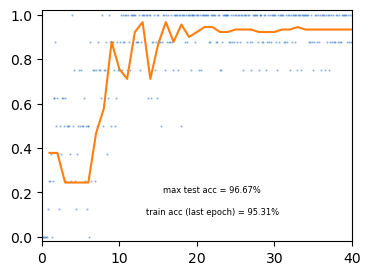

  0%|          | 0/40 [00:00<?, ?it/s]



model = iris_linear_maxplus:


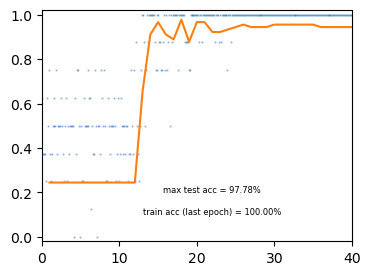

  0%|          | 0/40 [00:00<?, ?it/s]



model = iris_linear_minplus:


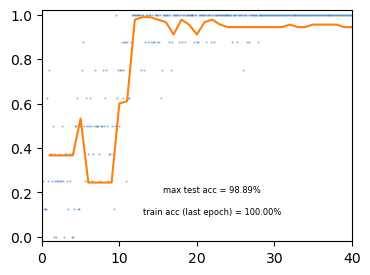

  0%|          | 0/40 [00:00<?, ?it/s]



model = iris_linear_logplus_m10:


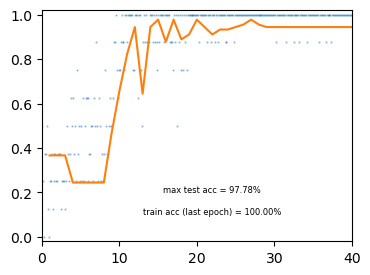

  0%|          | 0/40 [00:00<?, ?it/s]



model = iris_linear_logplust_m1:


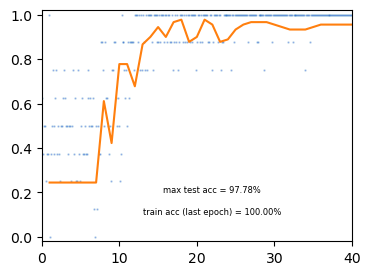

  0%|          | 0/40 [00:00<?, ?it/s]



model = iris_linear_logplust_p1:


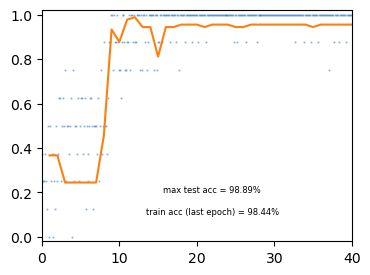

  0%|          | 0/40 [00:00<?, ?it/s]



model = iris_linear_logplust_p10:


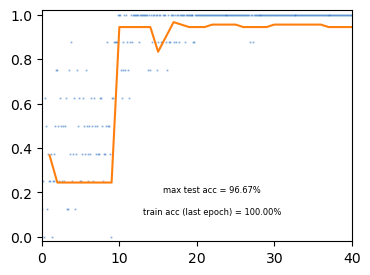

  0%|          | 0/40 [00:00<?, ?it/s]

train accuracies (last epoch): [0.953125, 1.0, 1.0, 1.0, 1.0, 0.984375, 1.0]
test accuracies: [0.9666666666666667, 0.9777777777777777, 0.9888888888888889, 0.9777777777777777, 0.9777777777777777, 0.9888888888888889, 0.9666666666666667]


In [11]:
iris_model_width = 4 # must be even for the number of parameters to match

iris_linear_relu = LinearReLU(
    iris_num_features, iris_num_classes, width=iris_model_width
)
iris_linear_relu.tag = "iris_linear_relu"

iris_linear_maxplus = LinearMaxPlus(
    iris_num_features, iris_num_classes, width=iris_model_width
)
iris_linear_maxplus.tag = "iris_linear_maxplus"

iris_linear_minplus = LinearMinPlus(
    iris_num_features, iris_num_classes, width=iris_model_width
)
iris_linear_minplus.tag = "iris_linear_minplus"

iris_linear_logplus_m10 = LinearLogPlus(
    iris_num_features, iris_num_classes, width=iris_model_width, mu=-10
)
iris_linear_logplus_m10.tag = "iris_linear_logplus_m10"

iris_linear_logplus_m1 = LinearLogPlus(
    iris_num_features, iris_num_classes, width=iris_model_width, mu=-1
)
iris_linear_logplus_m1.tag = "iris_linear_logplust_m1"

iris_linear_logplus_p1 = LinearLogPlus(
    iris_num_features, iris_num_classes, width=iris_model_width, mu=1
)
iris_linear_logplus_p1.tag = "iris_linear_logplust_p1"

iris_linear_logplus_p10 = LinearLogPlus(
    iris_num_features, iris_num_classes, width=iris_model_width, mu=10
)
iris_linear_logplus_p10.tag = "iris_linear_logplust_p10"

iris_models = [
    iris_linear_relu,
    iris_linear_maxplus,
    iris_linear_minplus,
    iris_linear_logplus_m10,
    iris_linear_logplus_m1,
    iris_linear_logplus_p1,
    iris_linear_logplus_p10,
]

iris_models = [m.to(device) for m in iris_models]

loss = nn.CrossEntropyLoss()
epochs = 40

iris_train100accs = []
iris_testaccs = []
for im, m in enumerate(iris_models):
    optimizer, scheduler = m.get_optimizer_and_scheduler(epochs, len(iris_train_loader))
    print(f"\n\nmodel = {m.tag}:")
    train100acc, testacc = train(
        m,
        device,
        iris_train_loader,
        iris_test_loader,
        optimizer,
        scheduler,
        loss,
        epochs
    )
    iris_train100accs.append(train100acc)
    iris_testaccs.append(testacc)

print(f"train accuracies (last epoch): {iris_train100accs}")
print(f"test accuracies: {iris_testaccs}")